In [1]:
#indir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/CHIP_b1_Control/cell_by_var/"
# indir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/CHIP_b1_Control/cells_vars/vcfpad_1"
# cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/cells_meta.tsv"
# outdir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/CHIP_b1_Control/som_clones/"
# condition = "Control"

# cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/cells_meta.tsv"
# condition = "Flt3l"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/somatic_variants/needle/peaks_all/Flt3l"
# indir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/peaks_all/CHIP_b1_Flt3l/cells_vars/vcfpad_1"


vars_f = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/peaks_all/variants.annotate.gene.vcf"
# cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/cells_meta.tsv"
# indir = "/data/Mito_Trace/output/somatic_variants/CHIP_dec172021/aggregate/needle_post/peaks_all/CHIP_b1_Control/cells_vars/vcfpad_1"
# condition = "Control" 
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/somatic_variants/needle/peaks_all/Control"

#papermill -p 
cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/cells_meta.tsv"
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/somatic_variants/regions_atac_peaks/gatk_mutect/post/pileup/Input/cells_vars/vcfpad_1"
condition = "Input"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/somatic_variants/gatk_mutect/peaks_atac_peaks/Input"

In [2]:
from glob import glob
from os.path import basename, join, exists
from src.utils.data_io import read_csv_multichar
import pandas as pd
from pandarallel import pandarallel
import seaborn as sns
import mplh.cluster_help as ch
import matplotlib.pyplot as plt

import numpy as np

fig_utils from mplh


In [3]:
%load_ext autoreload
%autoreload 2

## Read in af pileup and preprocess
- add condition to suffix for compatibility
- create var ID as posID_{nt}

In [4]:
vars_df = pd.read_csv(vars_f,sep='\t', index_col=0)
vars_df[["chr", "pos"]] = [x.split(":") for x in vars_df["Location"]]

if "ref" not in vars_df.columns:
    vars_df["ref"] = vars_df["#Uploaded_variation"].apply(lambda x: x.split("_")[-1].split("/")[0])
vars_df

,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,Extra,Gene Name,chr,pos,ref
0,GL000195.1_30801_C/A,GL000195.1:30801,A,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,GL000195.1,30801,C
1,GL000195.1_30924_T/C,GL000195.1:30924,C,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,GL000195.1,30924,T
2,GL000195.1_30956_G/A,GL000195.1:30956,A,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,GL000195.1,30956,G
3,GL000195.1_31916_G/T,GL000195.1:31916,T,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,GL000195.1,31916,G
4,GL000195.1_31919_C/T,GL000195.1:31919,T,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,GL000195.1,31919,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47609,chrY_56767254_T/A,chrY:56767254,A,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,chrY,56767254,T
47610,chrY_56768565_G/A,chrY:56768565,A,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,chrY,56768565,G
47611,chrY_56768763_T/A,chrY:56768763,A,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,chrY,56768763,T
47612,chrY_56768805_C/T,chrY:56768805,T,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,chrY,56768805,C


In [5]:
vars_df["posID"] = vars_df["Location"].str.replace(":", "_")
vars_df["var"] = vars_df["posID"]+"_"+vars_df["Allele"]
vars_df

,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,Extra,Gene Name,chr,pos,ref,posID,var
0,GL000195.1_30801_C/A,GL000195.1:30801,A,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,GL000195.1,30801,C,GL000195.1_30801,GL000195.1_30801_A
1,GL000195.1_30924_T/C,GL000195.1:30924,C,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,GL000195.1,30924,T,GL000195.1_30924,GL000195.1_30924_C
2,GL000195.1_30956_G/A,GL000195.1:30956,A,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,GL000195.1,30956,G,GL000195.1_30956,GL000195.1_30956_A
3,GL000195.1_31916_G/T,GL000195.1:31916,T,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,GL000195.1,31916,G,GL000195.1_31916,GL000195.1_31916_T
4,GL000195.1_31919_C/T,GL000195.1:31919,T,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,GL000195.1,31919,C,GL000195.1_31919,GL000195.1_31919_T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47609,chrY_56767254_T/A,chrY:56767254,A,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,chrY,56767254,T,chrY_56767254,chrY_56767254_A
47610,chrY_56768565_G/A,chrY:56768565,A,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,chrY,56768565,G,chrY_56768565,chrY_56768565_A
47611,chrY_56768763_T/A,chrY:56768763,A,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,chrY,56768763,T,chrY_56768763,chrY_56768763_A
47612,chrY_56768805_C/T,chrY:56768805,T,-,-,-,intergenic_variant,-,-,-,-,-,-,IMPACT=MODIFIER,NaN,chrY,56768805,C,chrY_56768805,chrY_56768805_T


In [6]:
if not exists(join(indir, "af.ref.pileup.tsv")):
    af = pd.read_csv(join(indir, "af.ref.pileup.tsv.gz"),sep='\t', compression='gzip')
else:
    af = pd.read_csv(join(indir, "af.ref.pileup.tsv"),sep='\t')

af["cell"] = af["cell"]+"_" + condition

af["var"] = af["posID"] + "_" + af["nt"]
af.head()

,Unnamed: 0,chr,pos,nt,count,BQ,cell,posID,coverage,AF,ID,isVar,var
0,82.0,chr1,2412404,A,3,33,CGCGCAATCGATGTAC-1_Input,chr1_2412404,3,1.0,chr1_2412404_A,True,chr1_2412404_A
1,88.0,chr1,2412410,C,3,37,CGCGCAATCGATGTAC-1_Input,chr1_2412410,3,1.0,chr1_2412410_C,False,chr1_2412410_C
2,90.0,chr1,2412412,G,3,37,CGCGCAATCGATGTAC-1_Input,chr1_2412412,3,1.0,chr1_2412412_G,False,chr1_2412412_G
3,111.0,chr1,2412460,C,3,37,CGCGCAATCGATGTAC-1_Input,chr1_2412460,3,1.0,chr1_2412460_C,False,chr1_2412460_C
4,114.0,chr1,2412463,G,3,37,CGCGCAATCGATGTAC-1_Input,chr1_2412463,3,1.0,chr1_2412463_G,False,chr1_2412463_G


## Drop chrM

In [7]:
af = af.loc[~(af["chr"] == 'chrM')]

vars_df = vars_df.loc[~(vars_df["chr"] == "chrM")]

print(af.shape)
print(vars_df.shape)
print(len(vars_df["var"].unique()))

(41127572, 13)
(34056, 20)
5425


### Read and preprocess clones

In [8]:
cells_meta = pd.read_csv(cells_meta_f,sep="\t").set_index("ID")
cells_meta["name"] = cells_meta.apply(lambda x: f"{x['donor']}_{x['lineage']}", axis=1)
cells_meta.head()

,lineage,donor,condition,name
ID,,,,
AAACGAAAGAATCAAC-1_Control,0,0,Control,0_0
AAATGAGAGAGACTCG-1_Control,0,0,Control,0_0
AACAAAGTCAAGTTGC-1_Control,0,0,Control,0_0
AACAAAGTCACATCCC-1_Control,0,0,Control,0_0
AACCAACGTTCATTTC-1_Control,0,0,Control,0_0


In [9]:
af["donor"] = af["cell"].map(cells_meta["donor"])
af["name"] = af["cell"].map(cells_meta["name"])



## Construct counts for each variants and ref

In [10]:
# af_mat = af.pivot(index="cell", columns="var", values="count").fillna(0)
# vars_meta = af_mat.columns
# ch.plot_cluster(af_mat, row_meta=cells_meta[["name", "donor"]], col_meta=af[["isVar"]], 
#                 col_clr_schemes="categorical", row_clr_schemes = "categorical")
# #plt.savefig(join(outdir, "ad_reference.png"))



# ## Groupby donor and clone and get number of cells > 0


# af = af.dropna(subset=["name", "donor"])



# ## Donors

# donors_df = af.groupby(["donor", "var", "nt"]).sum()["count"].reset_index()
# donors_df
# ch.plot_cluster(donors_df.pivot(index="donor", columns="var", values="count"), 
#                 col_clr_schemes='categorical', col_meta=af[["isVar"]])

# ## Clones

# clones_df = af.groupby(["name", "var", "nt"]).sum()["count"].reset_index()
# clones_mat = clones_df.pivot(index="name", columns="var", values="count").fillna(0)
# clones_df

# meta_clones_df = pd.DataFrame(index=clones_mat.index, data=[x.split("_")[0] for x in clones_mat.index], 
#                               columns=["Donor"])

# ch.plot_cluster(clones_mat, row_meta=meta_clones_df, row_clr_schemes="categorical")

# ## Clone sizes

# clones_df = af.groupby(["name", "var", "nt"]).size().to_frame("size").reset_index()
# clones_mat = clones_df.pivot(index="name", columns="var", values="size").fillna(0)
# clones_df

# meta_clones_df = pd.DataFrame(index=clones_mat.index, data=[x.split("_")[0] for x in clones_mat.index], 
#                               columns=["Donor"])

# ch.plot_cluster(clones_mat, row_meta=meta_clones_df, row_clr_schemes="categorical")

In [11]:
vars_df["Gene Name"] = vars_df["Gene Name"].fillna("")
vars_df["Gene Name"] = vars_df.apply(lambda x: x["Gene"] if x['Gene Name']=="" else x['Gene Name'] , axis=1)

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
vars_df = vars_df.drop_duplicates(subset=["var", "Gene Name", "Feature_type", "Consequence"]).sort_values("Gene Name").iloc[::-1]
vars_df.shape

(12063, 20)

In [13]:
print(f"Number of variants {len(vars_df['var'].unique())}")

Number of variants 5425


## For duplicated variants, add the additional gene info to first instance and remove the dup rows

In [14]:
def dups(df):
    if df.shape[0] == 0:
        return df.iloc[0]

    cons = ";".join(list(set(df["Consequence"].values)))
    feature = ";".join(list(set(df["Feature"].values)))
    gene_name = ";".join(list(set(df["Gene Name"].values)))
    out = df.iloc[0]
    out["Consequence"] = cons
    out["Feature"] = feature
    out["Gene Name"] = gene_name
    out.name = None
    return out



In [15]:
vars_df_rmdups = vars_df.groupby("var").apply(dups)
vars_df_rmdups = vars_df_rmdups[["Gene Name", "Feature_type", "Consequence", "posID", "ref", "Allele"]]
vars_df_rmdups.sort_values("Gene Name").iloc[::-1]

,Gene Name,Feature_type,Consequence,posID,ref,Allele
var,,,,,,
chr2_135531166_A,ZRANB3;R3HDM1,Transcript,5_prime_UTR_variant;non_coding_transcript_exon...,chr2_135531166,C,A
chr2_135531170_T,ZRANB3;R3HDM1,Transcript,5_prime_UTR_variant;upstream_gene_variant;non_...,chr2_135531170,A,T
chr19_58381143_T,ZNF837,Transcript,upstream_gene_variant,chr19_58381143,C,T
chr19_56121465_A,ZNF787,Transcript,upstream_gene_variant,chr19_56121465,G,A
chr19_56121508_T,ZNF787,Transcript,upstream_gene_variant,chr19_56121508,G,T
...,...,...,...,...,...,...
chr1_143206441_C,-,-,intergenic_variant,chr1_143206441,A,C
chr1_143206517_G,-,-,intergenic_variant,chr1_143206517,A,G
chr1_143212456_T,-,-,intergenic_variant,chr1_143212456,C,T


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'SNP (1) or insertion length')

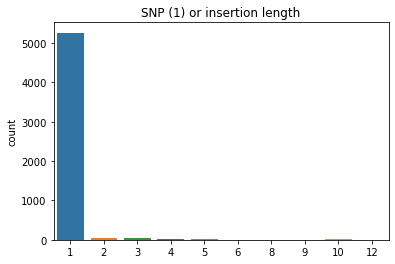

In [16]:
sns.countplot([len(x) for x in vars_df_rmdups["Allele"]])
plt.title("SNP (1) or insertion length")



In [17]:
len(set(vars_df_rmdups.index.values))

5425

# AF and reference

#### Theres an additional 800 variants in the af matrix

In [18]:
cells = af["cell"].unique()
#vrnts = af["var"].unique()

before cell removal
cells_meta (17298, 4)
cells_meta after (6263, 4)
donor-by-vars (2, 1141573)


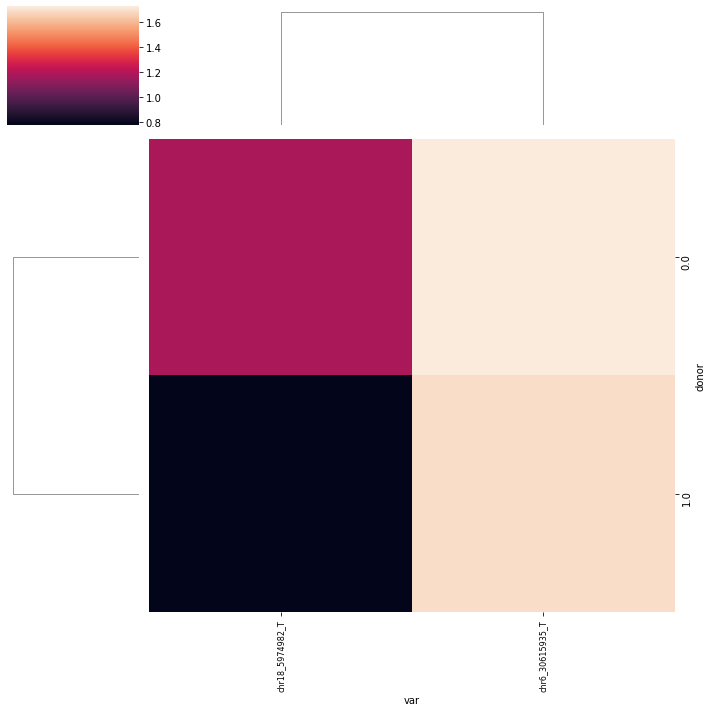

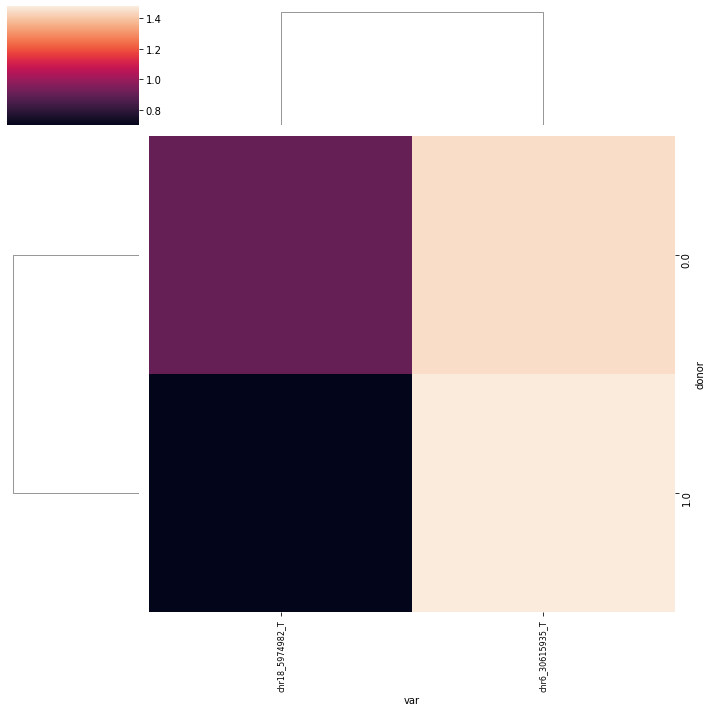

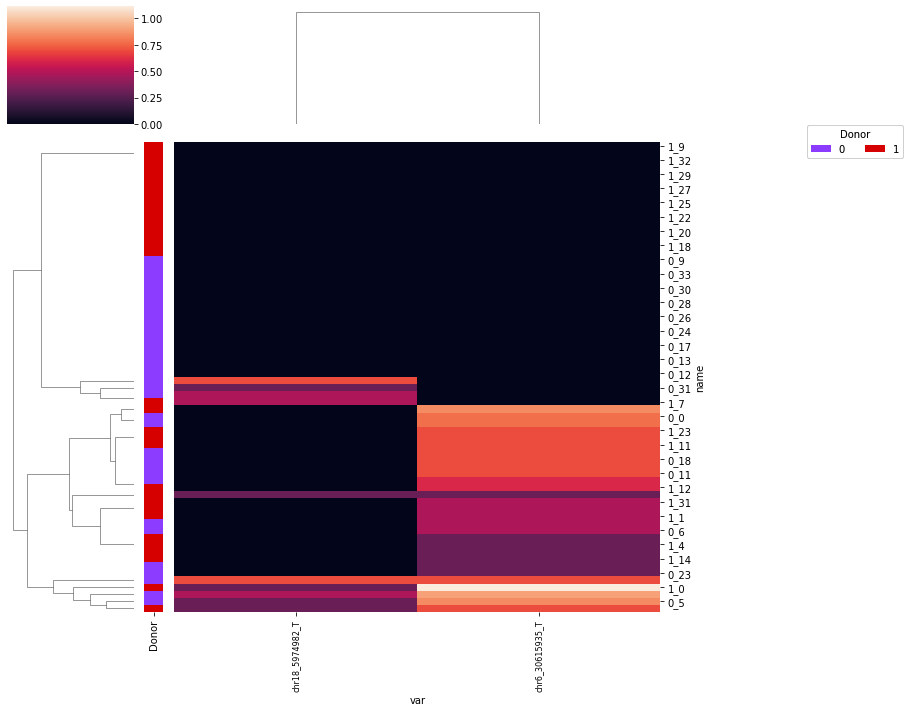

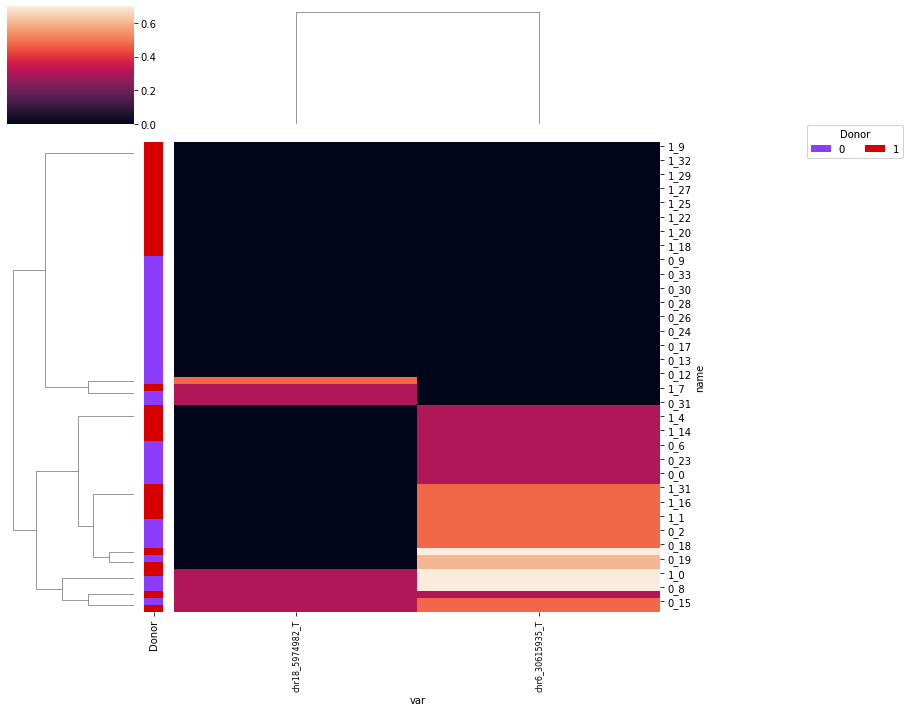

In [25]:

if af.shape[0] != 0:
    print("before cell removal")
    print('cells_meta', cells_meta.shape)
    curr_cells_meta = cells_meta.loc[cells_meta.index.isin(cells)]
#     try:
#         af_mat = af.pivot(index="cell", columns="var", values="count").fillna(0)
#         print('af', af_mat.shape)
#         print(f"Duplicated variants: {af_mat.columns.duplicated().sum()}")
#         print(f"matrix shape: {af_mat.shape}")
#         af_mat = af_mat.loc[af_mat.index.isin(curr_cells_meta.index)]
#         print('af after', af_mat.shape)
#         ch.plot_cluster(np.log10(1+af_mat.sample(min(af_mat.shape[0],1000))).sample(min(af_mat.shape[1],1000),axis=1), 
#                         row_meta=curr_cells_meta[["name", "donor"]], col_meta=af[["isVar"]], 
#                         col_clr_schemes="categorical", row_clr_schemes = "categorical")
#     except ValueError:
#         print("DF too large, not printing")
    
    print('cells_meta after', curr_cells_meta.shape)
    ## Donors
    donors_df = af.groupby(["donor", "var", "nt"]).sum()["count"].reset_index()

    ## i. Allele counts
    donors_mat = donors_df.pivot(index="donor", columns="var", values="count").fillna(0)
    donors_mat = donors_mat.loc[:, donors_mat.std(axis=0).sort_values()[::-1].index]
    print(f"donor-by-vars {donors_mat.shape}")
    sampled_vars = donors_mat.sample(n=min(1000,donors_mat.shape[1]),axis=1).columns
    ch.plot_cluster(np.log10(1+donors_mat.loc[:,sampled_vars]), col_clr_schemes='categorical')
    plt.tight_layout()
    plt.savefig(join(outdir, "donor_altAndRef_sumCounts.png"),bbox_inches='tight')

    ## ii. Clone sizes: Number of cells with the variant in donor
    ## Save donor variants
    donors_df = af.groupby(["donor", "var", "nt"]).size().to_frame("size").reset_index()
    donors_mat = donors_df.pivot(index="donor", columns="var", values="size").fillna(0)
    ch.plot_cluster(np.log10(1+donors_mat.loc[:,sampled_vars]))
    plt.tight_layout()
    plt.savefig(join(outdir, "donor_altAndRef_numCells.png"),bbox_inches='tight')
    donor_vars_meta = vars_df_rmdups.loc[vars_df_rmdups.index.isin(donors_mat.columns)]
    donor_vars_meta.to_csv(join(outdir, "donor_altAndRef_numCells.variants.tsv"),sep="\t")
    donors_mat.to_csv(join(outdir, "donor_altAndRef_numCells.csv"))

    ## Clones 
    # i. Allele counts
    clones_df = af.groupby(["name", "var", "nt"]).sum()["count"].reset_index()
    clones_mat = clones_df.pivot(index="name", columns="var", values="count").fillna(0)
    clones_df
    meta_clones_df = pd.DataFrame(index=clones_mat.index, data=[x.split("_")[0] for x in clones_mat.index], 
                                  columns=["Donor"])
    ch.plot_cluster(np.log10(1+clones_mat.loc[:,sampled_vars]), row_meta=meta_clones_df, row_clr_schemes="categorical")
    plt.tight_layout()
    plt.savefig(join(outdir, "clone_altAndRef_sumCounts.png"),bbox_inches='tight')

    ## ii. Clone sizes: Number of cells with the variant in clone
    clones_df = af.groupby(["name", "var", "nt"]).size().to_frame("size").reset_index()
    clones_mat = clones_df.pivot(index="name", columns="var", values="size").fillna(0)
    clones_mat.to_csv(join(outdir, "clones_altAndRef_numCells.csv"))
    clone_vars_meta = vars_df_rmdups.loc[vars_df_rmdups.index.isin(clones_mat.columns)]
    clone_vars_meta.to_csv(join(outdir, "clone_altAndRef_numCells.variants.tsv"),sep="\t")
    meta_clones_df = pd.DataFrame(index=clones_mat.index, data=[x.split("_")[0] for x in clones_mat.index], 
                                  columns=["Donor"])
    ch.plot_cluster(np.log10(1+clones_mat.loc[:,sampled_vars]), row_meta=meta_clones_df, row_clr_schemes="categorical")
    plt.tight_layout()
    plt.savefig(join(outdir, "clone_altAndRef_numCells.png"),bbox_inches='tight')


# AF called variants

## isVar, if there are any

In [ ]:
def top20_with_feat(df, vars_df_rmdups, f_save):
    df_vars_meta = vars_df_rmdups.loc[vars_df_rmdups.index.isin(df.columns)]
    print(df_vars_meta)
    # Remove without any feature
    df_vars_meta = df_vars_meta.loc[(df_vars_meta["Gene Name"]!="-")]
    df = df.loc[:, df_vars_meta.index]
    print('df before sort')
    print(df.head())
    if len(df) == 0:
        return df
    if (df.shape[1] != 0) and (df.shape[0] != 0):

        df_std = df.loc[:, df.std(axis=0).sort_values()[::-1].index]
        if df_std.isnull().all().all():
            print('null')
            print(df.head())
            return df
        else:
            df = df_std
        print('df after')
        print(df.shape)
        print(df.head())

        print(min(20, df.shape[1]))
        if df.shape[1] <= 1:
            sns.heatmap(np.log10(1+df))
        else:
            ch.plot_cluster(np.log10(1+df).iloc[:,:min(20, df.shape[1])], 
                            col_meta = df_vars_meta, col_clr_schemes="categorical")
        plt.tight_layout()
        plt.savefig(f_save,bbox_inches='tight')
        #plt.savefig(join(outdir, "df_alt_numCells_top20.png"))

    return df

In [ ]:
# top20_donor_feat = top20_with_feat(donors_mat, vars_df_rmdups, f_save = join(outdir, "top20_feature_donor_alt_numCells.png"))

# top20_donor_feat.head()

# vars_df_rmdups.loc[top20_donor_feat.columns]

# vars_df_rmdups.loc[top20_donor_feat.columns]

# top20_donor_feat.head()

## AF for variants (not reference)

In [ ]:
af_isVar = af[af["isVar"]]
var_cell_ids = af_isVar["cell"].unique()

In [ ]:
if af_isVar.shape[0] != 0:
    #af_isVar_mat = (af_isVar_mat+1)
    print('cells_meta', cells_meta.shape)
    curr_cells_meta = cells_meta.loc[cells_meta.index.isin(var_cell_ids)]

    ## Donors
    ## Counts in total
    donors_df = af_isVar.groupby(["donor", "var", "nt"]).sum()["count"].reset_index()
    donors_mat = donors_df.pivot(index="donor", columns="var", values="count").fillna(0)
    donors_mat = donors_mat.loc[:, donors_mat.std(axis=0).sort_values()[::-1].index]
    sampled_vars = donors_mat.sample(n=min(1000,donors_mat.shape[1]),axis=1).columns

    ch.plot_cluster(np.log10(1+donors_mat.loc[:,sampled_vars]))
    plt.tight_layout()
    plt.savefig(join(outdir, "donor_alt_sumCounts.png"),bbox_inches='tight')

    ## Number of cells with the variant in donor
    donors_df = af_isVar.groupby(["donor", "var", "nt"]).size().to_frame("size").reset_index()
    donors_mat = donors_df.pivot(index="donor", columns="var", values="size").fillna(0)
    donors_mat = donors_mat.loc[:, donors_mat.std(axis=0).sort_values()[::-1].index]
    donors_mat.to_csv(join(outdir, "donor_alt_numCells.csv"))
    
    donor_vars_meta = vars_df_rmdups.loc[vars_df_rmdups.index.isin(donors_mat.columns)]
    donor_vars_meta.to_csv(join(outdir, "donor_alt_numCells.variants.tsv"),sep="\t")
    sampled_vars = donors_mat.sample(n=min(1000,donors_mat.shape[0]),axis=1).columns

    ch.plot_cluster(np.log10(1+donors_mat.loc[:,sampled_vars]).iloc[:,:20])
    plt.tight_layout()
    plt.savefig(join(outdir, "donor_alt_numCells_top20.png"),bbox_inches='tight')
    
    
    top20_with_feat(donors_mat, donor_vars_meta, f_save = join(outdir, "top20_feature_donor_alt_numCells.png"))
    
    ch.plot_cluster(np.log10(1+donors_mat.loc[:,sampled_vars]), 
                    col_meta = donor_vars_meta[["Consequence"]], col_clr_schemes="categorical")
    plt.tight_layout()
    plt.savefig(join(outdir, "donor_alt_numCells.png"))


    ## Clones
    clones_df = af_isVar.groupby(["name", "var", "nt"]).sum()["count"].reset_index()
    clones_mat = clones_df.pivot(index="name", columns="var", values="count").fillna(0)
    clones_mat = clones_mat.loc[:, clones_mat.std(axis=0).sort_values()[::-1].index]
    
    ch.plot_cluster(np.log10(clones_mat.loc[:,sampled_vars]+1)) #, row_meta=, row_clr_schemes="categorical")
    plt.tight_layout()
    plt.savefig(join(outdir, "clone_alt_sumCounts.png"),bbox_inches='tight')
    

    ## Clone sizes
    clones_df = af_isVar.groupby(["name", "var", "nt"]).size().to_frame("size").reset_index()
    clones_mat = clones_df.pivot(index="name", columns="var", values="size").fillna(0)
    clones_mat = clones_mat.loc[:, clones_mat.std(axis=0).sort_values()[::-1].index]
    
    meta_clones_df = pd.DataFrame(index=clones_mat.index, data=[x.split("_")[0] for x in clones_mat.index], 
                                  columns=["Donor"])
    clones_mat.to_csv(join(outdir, "clones_alt_numCells.csv"))
    clone_vars_meta = vars_df_rmdups.loc[vars_df_rmdups.index.isin(clones_mat.columns)] #vars_df_rmdups.loc[clones_mat.columns]
    clone_vars_meta.to_csv(join(outdir, "clone_alt_numCells.variants.tsv"),sep="\t")
    
    top20_with_feat(clones_mat, clone_vars_meta, f_save = join(outdir, "top20_feature_clone_alt_numCells.png"))
    
    ch.plot_cluster(np.log10(clones_mat.loc[:,sampled_vars]+1).iloc[:,:20], 
                    col_meta = clone_vars_meta, col_clr_schemes="categorical")
    plt.tight_layout()
    plt.savefig(join(outdir, "clone_alt_numCells_top20.png"),bbox_inches='tight')
    
    ch.plot_cluster(np.log10(clones_mat.loc[:,sampled_vars]+1), 
                    col_meta = clone_vars_meta[["Consequence"]], col_clr_schemes="categorical",
                    row_meta=meta_clones_df, row_clr_schemes="categorical")
    plt.tight_layout()
    plt.savefig(join(outdir, "clone_alt_numCells.png"),bbox_inches='tight')


In [ ]:
# clones_mat

# vars_df_rmdups.loc[vars_df_rmdups.index.isin(clones_mat.columns)]

# vars_df.set_index("var").loc[vars_df.index.isin(clones_mat.columns)]

# clones_mat.columns.duplicated().sum()

# vars_df_rmdups

# clone_vars_meta